In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#dataset load
drebin_all = pd.read_csv('drebin.csv', 
                         usecols= [*range(0, 6),*range(7, 13),*range(14,19)
                                  ,21,23,24,*range(28,38),41,43,46,48,51,54,
                                   57,58,59,62,64,68,70,78,80,*range(83,87),
                                   *range(92, 95),98,101,102,104,109,123,128,
                                   140,142,145,147,148,152,155,156,158,167,
                                   171,172,180,190,215])

/home/galib/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#drebin_all.info()
X = drebin_all.iloc[0:,0:73]  #independent columns
y = drebin_all.iloc[0:,-1]
X["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [4]:
y = y.map(dict(S=1, B=0))

In [5]:
y[1]

1

In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.5, random_state = 0)


In [7]:
#mandatory import 
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from sklearn.feature_selection import RFE

In [8]:
pre = []
rec = []
fs = []
acc = []
auc = []
def clear_metrics(): 
    pre.clear()
    rec.clear()
    fs.clear()
    acc.clear()
    auc.clear()

In [9]:
import csv
def results_to_csv(title):
    with open(title+ '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy','Precision', 'Recall', 'F1','AUC'])
        writer.writerows(zip(acc, pre, rec, fs, auc))
        
def allscore(scores,i):
    acc.insert(i,scores['test_accuracy'].mean())
    fs.insert(i,scores['test_f1'].mean())
    pre.insert(i,scores['test_precision'].mean())
    rec.insert(i,scores['test_recall'].mean())
    auc.insert(i,scores['test_roc_auc'].mean())
    print("Accuracy: %0.4f   (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("Precision: %0.4f   (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_accuracy'].std() * 2))
    print("Recall: %0.4f   (+/- %0.4f)" % (scores['test_recall'].mean(), scores['test_accuracy'].std() * 2))
    print("F-1 Score: %0.4f   (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_accuracy'].std() * 2))
    print("ROC-AUC: %0.4f   (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_accuracy'].std() * 2))
def run_randomForest(X,y, i=0):
    scoring = ['precision', 'recall', 'f1','accuracy','roc_auc']
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=10, n_jobs=-1,
                        scoring=scoring, return_train_score=False)
    print('Classification Report for Random Forest:   ', i)
    allscore(scores,i)
def incremental_plot(i,j,title, x_axis = "Number of Features"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = pre
    y2 = rec
    y3 = acc
    y4 = fs

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Performance Metrics")
    ax.plot(x,y1, mew = 1, label='Precision') #mew = marker width
    ax.plot(x,y2,  mew = 1, label='Recall') #mew = marker width
    ax.plot(x,y3,  mew = 1, label='Accuracy') #mew = marker width
    ax.plot(x,y4, mew = 1, label='F-1 Score') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    plt.savefig(title + '.png', bbox_inches='tight', pad_inches=.1)
def incremental_plot_auc(i,j,title, x_axis = "Number of Features"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = auc
 

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("ROC-AUC Score")
    ax.plot(x,y1, mew = 1, label='ROC-AUC') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    plt.savefig(title + '_AUC.png', bbox_inches='tight', pad_inches=.1)
    
    

In [10]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col
def grouped_correlated(X):
    corr_features = get_correlation(X, 0.85)
    print(corr_features)
    X_uncorrelated = X.drop(labels = corr_features, axis =1)
    corrmat = X.corr()
    corrdata = corrmat.abs().stack()
    corrdata = corrdata.sort_values(ascending=False)
    corrdata = corrdata[corrdata>0.85]
    corrdata = corrdata[corrdata<1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['features1', 'features2', 'corr_value']
    print(corrdata)
    
   
    top_corr_features = corrmat.index
    plt.figure(figsize=(24,24))
    #plot heat map
    g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
    bottom, top = g.get_ylim()
    g.set_ylim(bottom + 0.5, top - 0.5)
    figure = g.get_figure()    
    figure.savefig('Correlation', dpi=400, bbox_inches='tight', pad_inches=.1)
    grouped_feature_list = []
    correlated_groups_list = []
    for feature in corrdata.features1.unique():
        if feature not in grouped_feature_list:
            correlated_block = corrdata[corrdata.features1 == feature]
            grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
            correlated_groups_list.append(correlated_block)
    #Feature Importance based on tree based classifiers 

    important_features = []
    for group in correlated_groups_list:
        features = list(group.features1.unique()) + list(group.features2.unique())
        rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
        rf.fit(X[features], y)

        importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
        importance.columns = ['features', 'importance']
        importance.sort_values(by = 'importance', ascending = False, inplace = True)
        feat = importance.iloc[0]
        important_features.append(feat)
    important_features= pd.DataFrame(important_features)
    important_features.reset_index(inplace=True, drop = True)
    important_features
    features_to_consider = set(important_features['features'])
    features_to_discard = set(corr_features) - set(features_to_consider)
    features_to_discard = list(features_to_discard)
    X_grouped_correlated = X.drop(labels = features_to_discard, axis = 1)
    print (X_grouped_correlated.shape)
    return X_grouped_correlated
def to_dataframe(X):
    print(X.shape)
    X_return = pd.DataFrame(data=X,
          index=np.arange(1, X.shape[0]+1), columns=np.arange(1, X.shape[1]+1))
    
    return X_return

(15036, 20)
{3, 4, 5, 6}
    features1  features2  corr_value
0           3          5    0.994622
1           5          3    0.994622
2           5          2    0.984796
3           2          5    0.984796
4           2          3    0.983198
5           3          2    0.983198
6           4          1    0.963364
7           1          4    0.963364
8           1          6    0.881938
9           6          1    0.881938
10          4          6    0.861441
11          6          4    0.861441
(15036, 17)


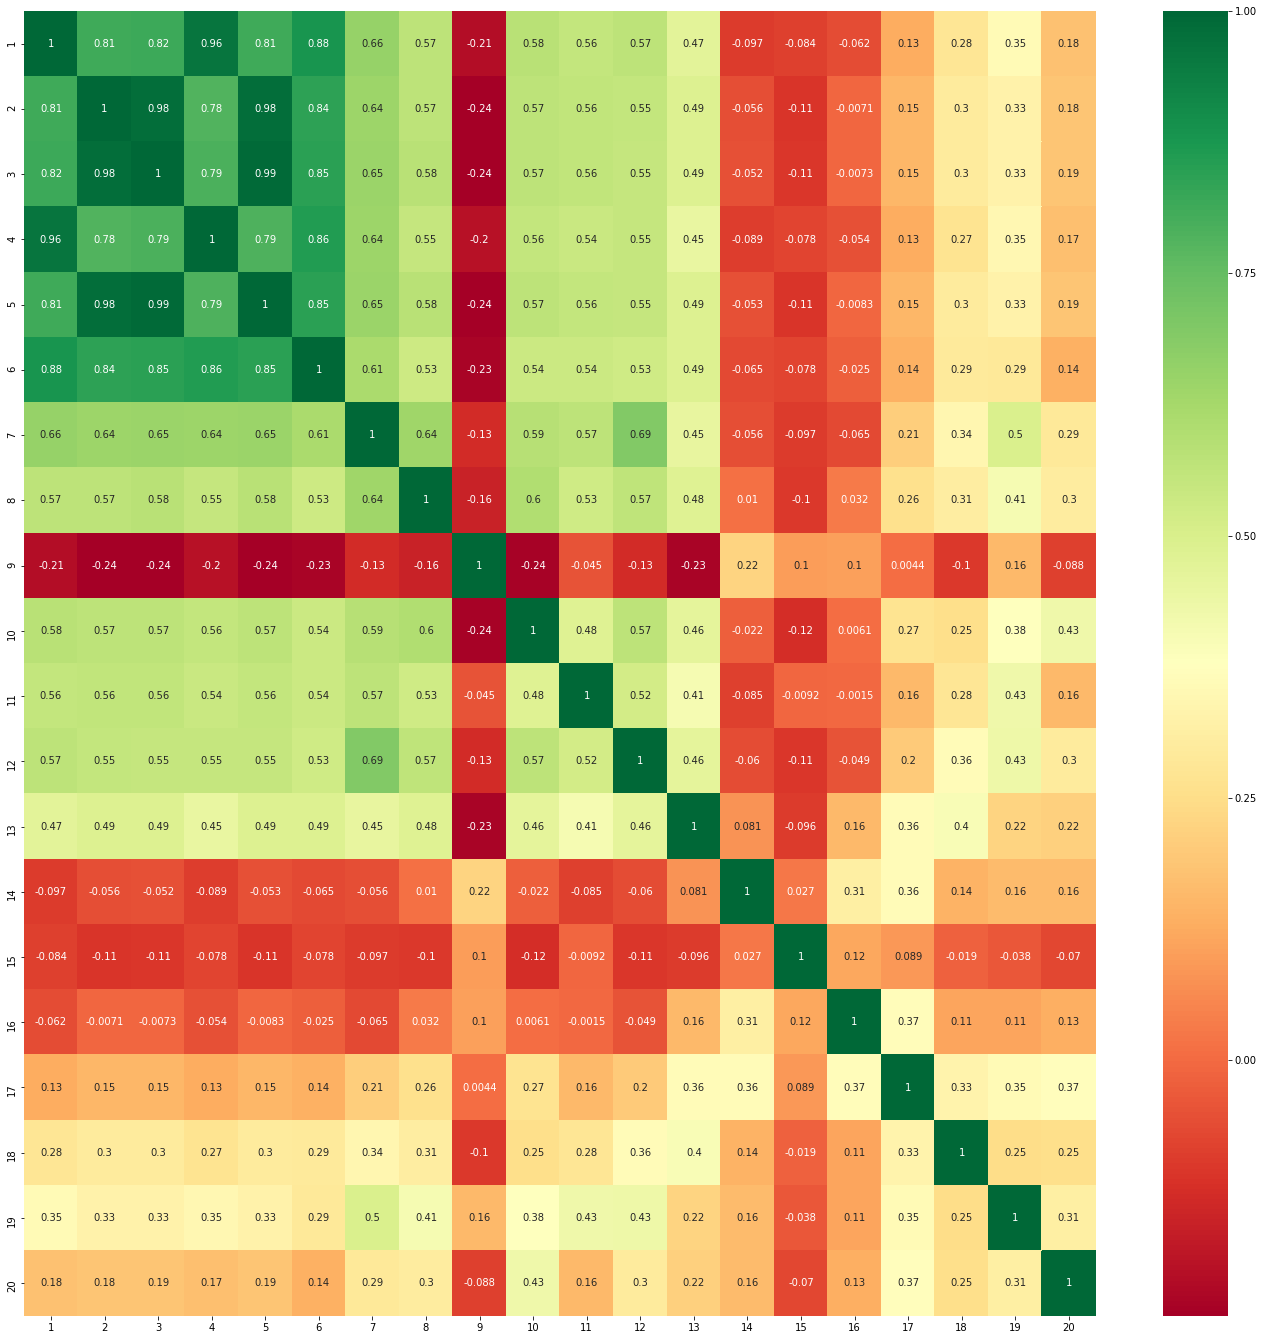

In [132]:
X_grouped = grouped_correlated(to_dataframe(X_optimal_gradient))

## Feature Importance using SelectKBest, chi2, f-score

In [548]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['APIs','Score']  #naming the dataframe columns

In [14]:
clear_metrics()
#X_top_feat_imps
for index in range(1,74,1):
    top_api_indexes = []
    top_api_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_api_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7509   (+/- 0.0343)
Precision: 0.5989   (+/- 0.0343)
Recall: 0.9452   (+/- 0.0343)
F-1 Score: 0.7331   (+/- 0.0343)
ROC-AUC: 0.7930   (+/- 0.0343)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7682   (+/- 0.0349)
Precision: 0.6265   (+/- 0.0349)
Recall: 0.8915   (+/- 0.0349)
F-1 Score: 0.7357   (+/- 0.0349)
ROC-AUC: 0.8164   (+/- 0.0349)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7695   (+/- 0.0334)
Precision: 0.6281   (+/- 0.0334)
Recall: 0.8915   (+/- 0.0334)
F-1 Score: 0.7368   (+/- 0.0334)
ROC-AUC: 0.8178   (+/- 0.0334)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.7691   (+/- 0.0326)
Precision: 0.6276   (+/- 0.0326)
Recall: 0.8915   (+/- 0.0326)
F-1 Score: 0.7365   (+/- 0.0326)
ROC-AUC: 0.8178   (+/- 0.0326)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.7703   (+/- 0.0335)
Precision: 0.6292   (+/- 0.0335)
Recall: 0.8908   (+

Classification Report for Random Forest:    39
Accuracy: 0.9601   (+/- 0.0094)
Precision: 0.9671   (+/- 0.0094)
Recall: 0.9213   (+/- 0.0094)
F-1 Score: 0.9435   (+/- 0.0094)
ROC-AUC: 0.9901   (+/- 0.0094)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9610   (+/- 0.0079)
Precision: 0.9697   (+/- 0.0079)
Recall: 0.9213   (+/- 0.0079)
F-1 Score: 0.9447   (+/- 0.0079)
ROC-AUC: 0.9898   (+/- 0.0079)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9637   (+/- 0.0083)
Precision: 0.9677   (+/- 0.0083)
Recall: 0.9309   (+/- 0.0083)
F-1 Score: 0.9488   (+/- 0.0083)
ROC-AUC: 0.9912   (+/- 0.0083)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9669   (+/- 0.0083)
Precision: 0.9709   (+/- 0.0083)
Recall: 0.9368   (+/- 0.0083)
F-1 Score: 0.9534   (+/- 0.0083)
ROC-AUC: 0.9924   (+/- 0.0083)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9677   (+/- 0.0076)
Precision: 0.9716   (+/- 0.0076)
Recall: 0.9382   (+/

In [15]:
title = "Feature Selection using SelectKBest(Chi-Square Test)"
results_to_csv(title)

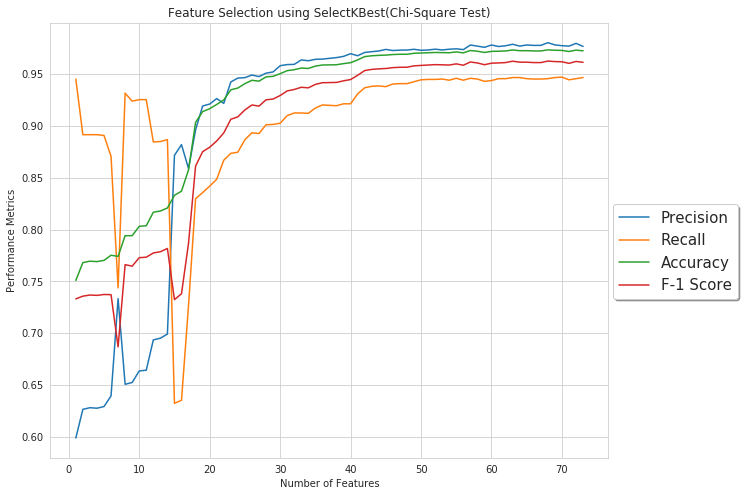

In [16]:
incremental_plot(1,74,title)

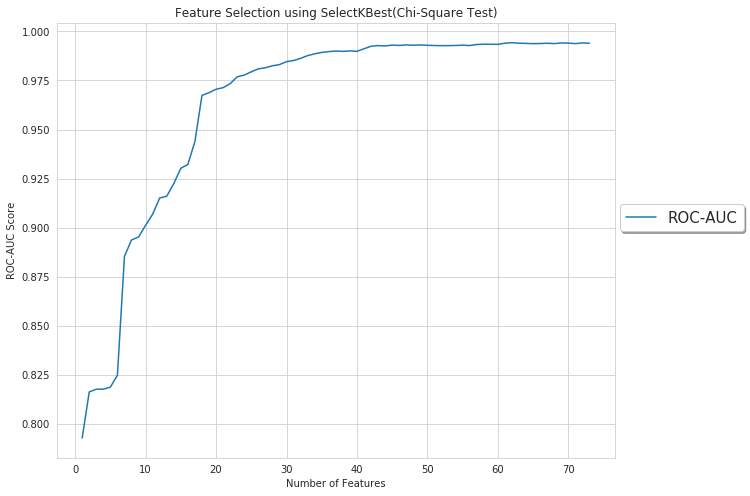

In [17]:
incremental_plot_auc(1,74,title)

In [18]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['APIs','Score']  #naming the dataframe columns

In [61]:
featureScores.Score.nlargest(5).index

Int64Index([1, 0, 2, 4, 5], dtype='int64')

In [19]:
clear_metrics()
#X_top_feat_imps
for index in range(1,74,1):
    top_api_indexes = []
    top_api_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_api_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7479   (+/- 0.0282)
Precision: 0.5997   (+/- 0.0282)
Recall: 0.9140   (+/- 0.0282)
F-1 Score: 0.7241   (+/- 0.0282)
ROC-AUC: 0.7839   (+/- 0.0282)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7682   (+/- 0.0349)
Precision: 0.6265   (+/- 0.0349)
Recall: 0.8915   (+/- 0.0349)
F-1 Score: 0.7357   (+/- 0.0349)
ROC-AUC: 0.8164   (+/- 0.0349)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7695   (+/- 0.0334)
Precision: 0.6281   (+/- 0.0334)
Recall: 0.8915   (+/- 0.0334)
F-1 Score: 0.7368   (+/- 0.0334)
ROC-AUC: 0.8178   (+/- 0.0334)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.7691   (+/- 0.0326)
Precision: 0.6276   (+/- 0.0326)
Recall: 0.8915   (+/- 0.0326)
F-1 Score: 0.7365   (+/- 0.0326)
ROC-AUC: 0.8178   (+/- 0.0326)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.7752   (+/- 0.0419)
Precision: 0.6395   (+/- 0.0419)
Recall: 0.8706   (+

Classification Report for Random Forest:    39
Accuracy: 0.9633   (+/- 0.0097)
Precision: 0.9683   (+/- 0.0097)
Recall: 0.9290   (+/- 0.0097)
F-1 Score: 0.9482   (+/- 0.0097)
ROC-AUC: 0.9902   (+/- 0.0097)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9634   (+/- 0.0090)
Precision: 0.9684   (+/- 0.0090)
Recall: 0.9294   (+/- 0.0090)
F-1 Score: 0.9484   (+/- 0.0090)
ROC-AUC: 0.9912   (+/- 0.0090)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9683   (+/- 0.0082)
Precision: 0.9721   (+/- 0.0082)
Recall: 0.9397   (+/- 0.0082)
F-1 Score: 0.9555   (+/- 0.0082)
ROC-AUC: 0.9922   (+/- 0.0082)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9674   (+/- 0.0069)
Precision: 0.9677   (+/- 0.0069)
Recall: 0.9415   (+/- 0.0069)
F-1 Score: 0.9544   (+/- 0.0069)
ROC-AUC: 0.9923   (+/- 0.0069)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9681   (+/- 0.0075)
Precision: 0.9699   (+/- 0.0075)
Recall: 0.9412   (+/

In [20]:
title = "Feature Selection using SelectKBest(ANOVA F-value)"
results_to_csv(title)

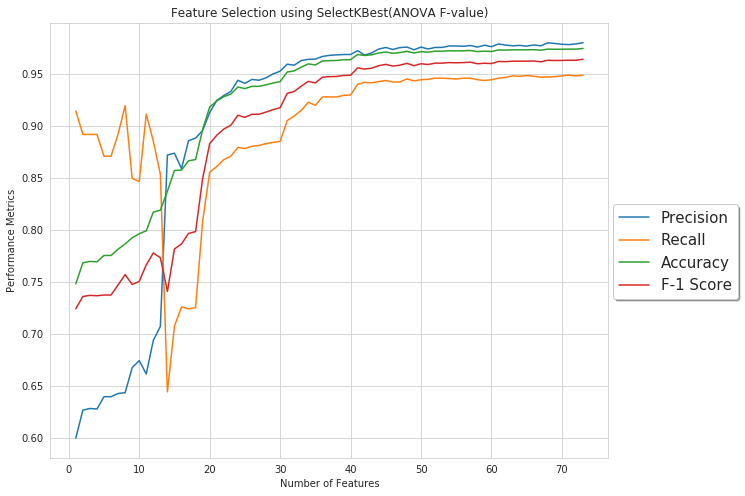

In [21]:
incremental_plot(1,74,title)

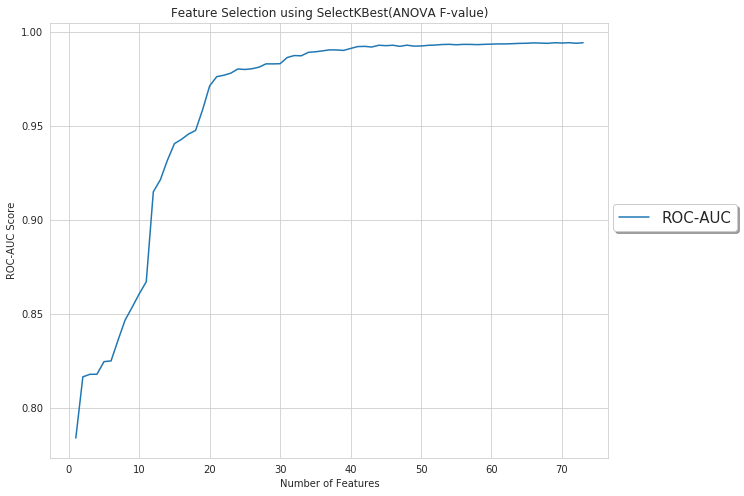

In [22]:
incremental_plot_auc(1,74,title)

In [31]:
X_top_feat_imps.shape

(7518, 73)

## Feature Importance (feature_importances_)

In [11]:
#RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_validate.columns)

In [70]:
clear_metrics()
#X_top_feat_imps
for index in range(1,74,1):
    top_api_indexes = []
    top_api_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7530   (+/- 0.0238)
Precision: 0.8100   (+/- 0.0238)
Recall: 0.4151   (+/- 0.0238)
F-1 Score: 0.5482   (+/- 0.0238)
ROC-AUC: 0.6798   (+/- 0.0238)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7803   (+/- 0.0211)
Precision: 0.9728   (+/- 0.0211)
Recall: 0.4040   (+/- 0.0211)
F-1 Score: 0.5703   (+/- 0.0211)
ROC-AUC: 0.8523   (+/- 0.0211)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8739   (+/- 0.0245)
Precision: 0.8555   (+/- 0.0245)
Recall: 0.7846   (+/- 0.0245)
F-1 Score: 0.8182   (+/- 0.0245)
ROC-AUC: 0.9072   (+/- 0.0245)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8744   (+/- 0.0255)
Precision: 0.8587   (+/- 0.0255)
Recall: 0.7824   (+/- 0.0255)
F-1 Score: 0.8185   (+/- 0.0255)
ROC-AUC: 0.9081   (+/- 0.0255)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8812   (+/- 0.0311)
Precision: 0.8869   (+/- 0.0311)
Recall: 0.7706   (+

Classification Report for Random Forest:    39
Accuracy: 0.9703   (+/- 0.0088)
Precision: 0.9741   (+/- 0.0088)
Recall: 0.9434   (+/- 0.0088)
F-1 Score: 0.9583   (+/- 0.0088)
ROC-AUC: 0.9928   (+/- 0.0088)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9719   (+/- 0.0090)
Precision: 0.9756   (+/- 0.0090)
Recall: 0.9463   (+/- 0.0090)
F-1 Score: 0.9606   (+/- 0.0090)
ROC-AUC: 0.9927   (+/- 0.0090)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9709   (+/- 0.0068)
Precision: 0.9734   (+/- 0.0068)
Recall: 0.9456   (+/- 0.0068)
F-1 Score: 0.9591   (+/- 0.0068)
ROC-AUC: 0.9930   (+/- 0.0068)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9717   (+/- 0.0098)
Precision: 0.9760   (+/- 0.0098)
Recall: 0.9452   (+/- 0.0098)
F-1 Score: 0.9602   (+/- 0.0098)
ROC-AUC: 0.9924   (+/- 0.0098)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9725   (+/- 0.0082)
Precision: 0.9767   (+/- 0.0082)
Recall: 0.9467   (+/

In [71]:
title = "Feature Selection using Random Forest Classifier - Feature Importances"
results_to_csv(title)

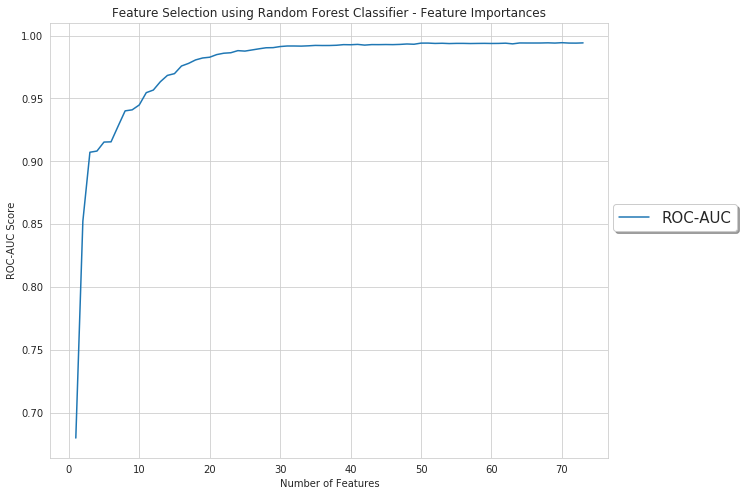

In [72]:
incremental_plot_auc(1,74, title)

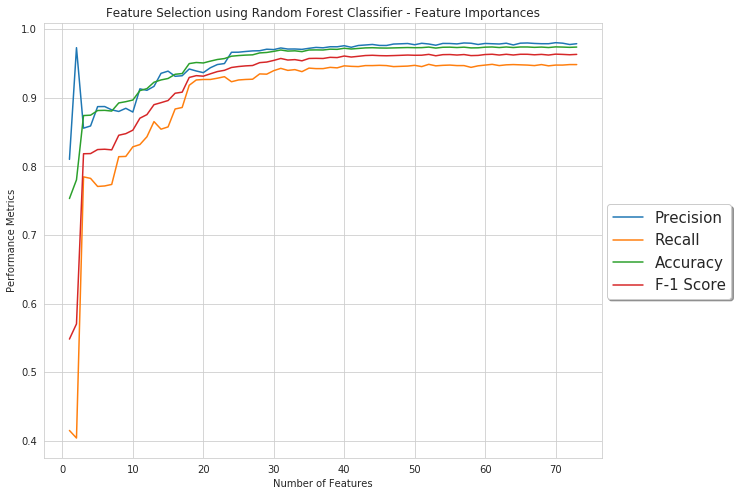

In [73]:
incremental_plot(1,74, title)


In [264]:
#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

In [75]:
clear_metrics()
X_top_feat_imps
for index in range(1,74,1):
    top_api_indexes = []
    top_api_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7530   (+/- 0.0238)
Precision: 0.8100   (+/- 0.0238)
Recall: 0.4151   (+/- 0.0238)
F-1 Score: 0.5482   (+/- 0.0238)
ROC-AUC: 0.6798   (+/- 0.0238)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7760   (+/- 0.0188)
Precision: 0.9704   (+/- 0.0188)
Recall: 0.3930   (+/- 0.0188)
F-1 Score: 0.5588   (+/- 0.0188)
ROC-AUC: 0.8660   (+/- 0.0188)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7805   (+/- 0.0204)
Precision: 0.9648   (+/- 0.0204)
Recall: 0.4085   (+/- 0.0204)
F-1 Score: 0.5732   (+/- 0.0204)
ROC-AUC: 0.8795   (+/- 0.0204)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8844   (+/- 0.0320)
Precision: 0.8485   (+/- 0.0320)
Recall: 0.8290   (+/- 0.0320)
F-1 Score: 0.8384   (+/- 0.0320)
ROC-AUC: 0.9325   (+/- 0.0320)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8852   (+/- 0.0306)
Precision: 0.8521   (+/- 0.0306)
Recall: 0.8268   (+

Classification Report for Random Forest:    39
Accuracy: 0.9706   (+/- 0.0082)
Precision: 0.9755   (+/- 0.0082)
Recall: 0.9426   (+/- 0.0082)
F-1 Score: 0.9587   (+/- 0.0082)
ROC-AUC: 0.9926   (+/- 0.0082)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9713   (+/- 0.0077)
Precision: 0.9763   (+/- 0.0077)
Recall: 0.9437   (+/- 0.0077)
F-1 Score: 0.9596   (+/- 0.0077)
ROC-AUC: 0.9925   (+/- 0.0077)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9703   (+/- 0.0085)
Precision: 0.9730   (+/- 0.0085)
Recall: 0.9445   (+/- 0.0085)
F-1 Score: 0.9584   (+/- 0.0085)
ROC-AUC: 0.9927   (+/- 0.0085)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9710   (+/- 0.0073)
Precision: 0.9738   (+/- 0.0073)
Recall: 0.9456   (+/- 0.0073)
F-1 Score: 0.9593   (+/- 0.0073)
ROC-AUC: 0.9930   (+/- 0.0073)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9721   (+/- 0.0062)
Precision: 0.9764   (+/- 0.0062)
Recall: 0.9460   (+/

In [76]:
title = "Feature Selection using Extra Trees Classifier Feature - Importances"
results_to_csv(title)

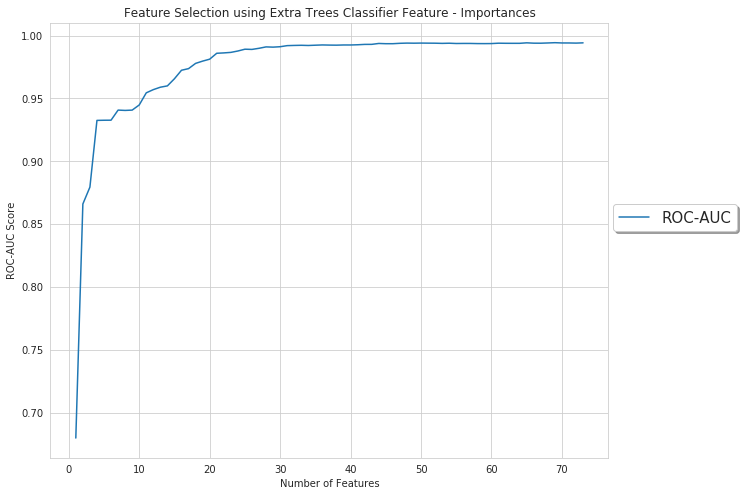

In [77]:
incremental_plot_auc(1,74, title)

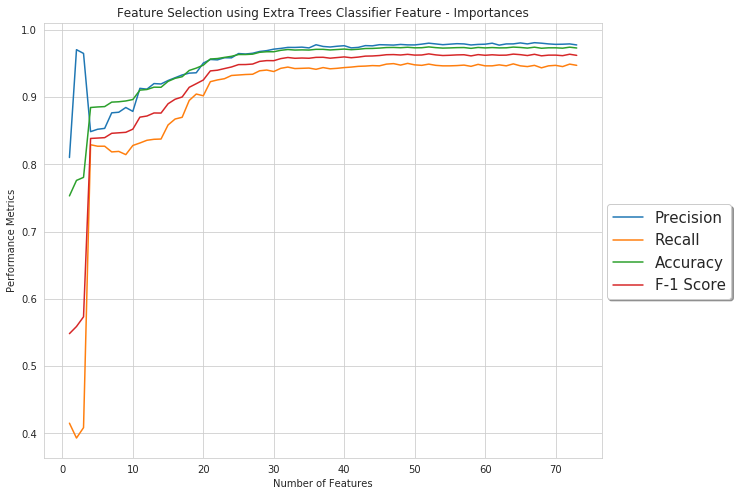

In [78]:
incremental_plot(1,74, title)


## Feature Selection Based on Mutual Information (Entropy) Gain

In [79]:
from sklearn.feature_selection import mutual_info_classif

In [80]:
mi = mutual_info_classif(X_train, y_train)

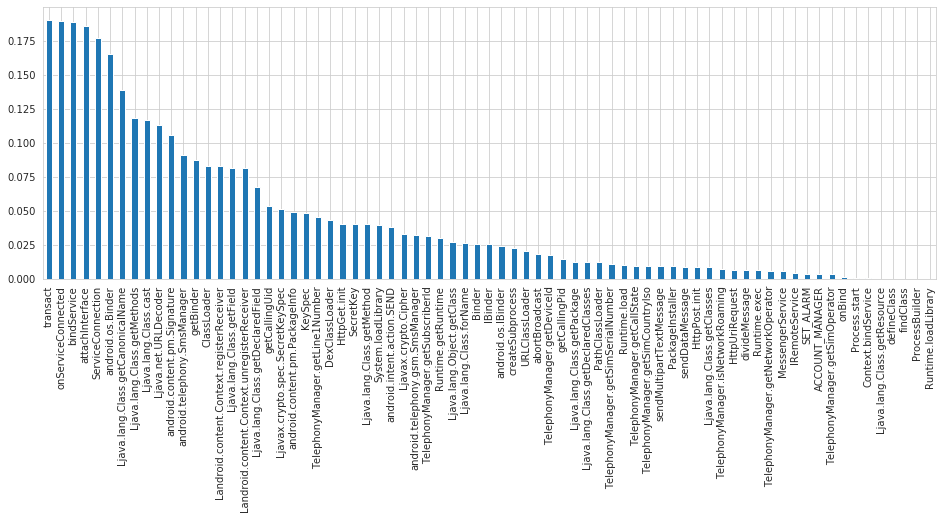

In [261]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
mi.plot.bar(figsize = (16,5))

In [82]:
clear_metrics()
for index in range(1, 74,1):
    top_api_indexes = []
    top_api_indexes = mi.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7459   (+/- 0.0279)
Precision: 0.5977   (+/- 0.0279)
Recall: 0.9129   (+/- 0.0279)
F-1 Score: 0.7223   (+/- 0.0279)
ROC-AUC: 0.7821   (+/- 0.0279)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7494   (+/- 0.0277)
Precision: 0.6015   (+/- 0.0277)
Recall: 0.9125   (+/- 0.0277)
F-1 Score: 0.7249   (+/- 0.0277)
ROC-AUC: 0.7852   (+/- 0.0277)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7691   (+/- 0.0344)
Precision: 0.6279   (+/- 0.0344)
Recall: 0.8901   (+/- 0.0344)
F-1 Score: 0.7362   (+/- 0.0344)
ROC-AUC: 0.8173   (+/- 0.0344)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.7691   (+/- 0.0326)
Precision: 0.6276   (+/- 0.0326)
Recall: 0.8915   (+/- 0.0326)
F-1 Score: 0.7365   (+/- 0.0326)
ROC-AUC: 0.8178   (+/- 0.0326)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.7703   (+/- 0.0335)
Precision: 0.6292   (+/- 0.0335)
Recall: 0.8908   (+

Classification Report for Random Forest:    39
Accuracy: 0.9694   (+/- 0.0051)
Precision: 0.9729   (+/- 0.0051)
Recall: 0.9419   (+/- 0.0051)
F-1 Score: 0.9570   (+/- 0.0051)
ROC-AUC: 0.9914   (+/- 0.0051)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9685   (+/- 0.0078)
Precision: 0.9706   (+/- 0.0078)
Recall: 0.9415   (+/- 0.0078)
F-1 Score: 0.9558   (+/- 0.0078)
ROC-AUC: 0.9915   (+/- 0.0078)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9693   (+/- 0.0094)
Precision: 0.9721   (+/- 0.0094)
Recall: 0.9423   (+/- 0.0094)
F-1 Score: 0.9569   (+/- 0.0094)
ROC-AUC: 0.9915   (+/- 0.0094)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9682   (+/- 0.0058)
Precision: 0.9706   (+/- 0.0058)
Recall: 0.9408   (+/- 0.0058)
F-1 Score: 0.9554   (+/- 0.0058)
ROC-AUC: 0.9917   (+/- 0.0058)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9675   (+/- 0.0068)
Precision: 0.9684   (+/- 0.0068)
Recall: 0.9412   (+/

In [83]:
title = "Feature Selection using Mutual Information Gain (Entropy)"
results_to_csv(title)

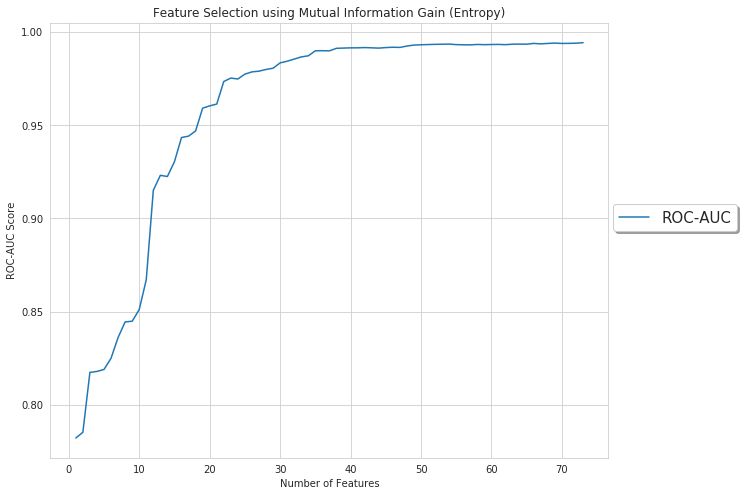

In [84]:
incremental_plot_auc(1,74, title)

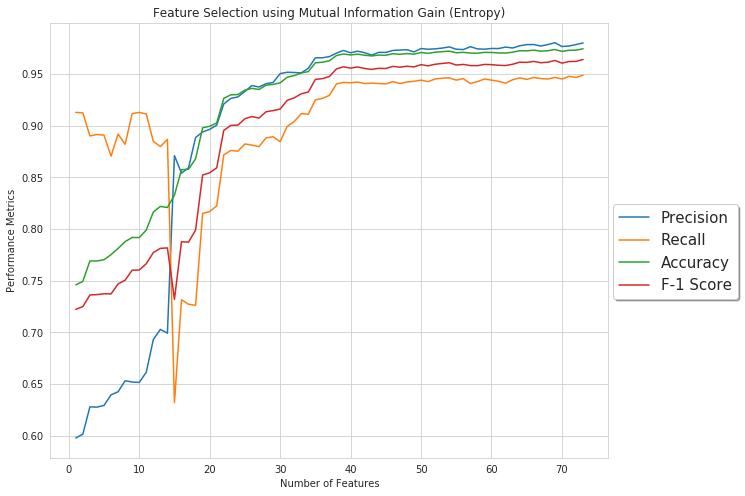

In [85]:
incremental_plot(1,74, title)


In [262]:
top_api_indexes = mi.nlargest(30).index
X_top_feat_imps = X.loc[:,top_api_indexes ]
print(X_top_feat_imps.shape)
run_randomForest(X_top_feat_imps,y, index)

(15036, 30)
Classification Report for Random Forest:    31
Accuracy: 0.9464   (+/- 0.0114)
Precision: 0.9571   (+/- 0.0114)
Recall: 0.8953   (+/- 0.0114)
F-1 Score: 0.9251   (+/- 0.0114)
ROC-AUC: 0.9863   (+/- 0.0114)


## Feature Selection Based on Univariate ROC_AUC for Classification

In [256]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for feature in X_train.columns:
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train[feature].to_frame(), y_train)
    y_pred = clf.predict(X_validate[feature].to_frame())
    roc_auc.append(roc_auc_score(y_validate, y_pred))

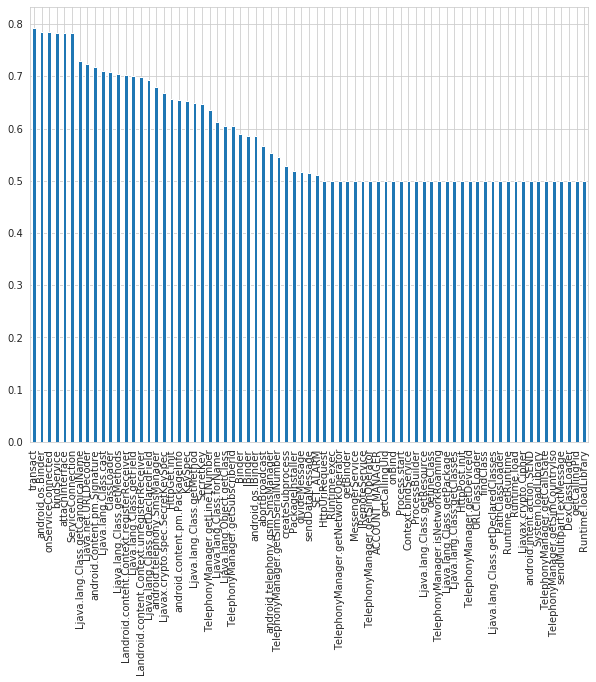

In [257]:
roc_values = pd.Series(roc_auc)
roc_values.index = X_train.columns
roc_values.sort_values(ascending =False, inplace = True)
roc_values.plot.bar()

In [258]:
sel = roc_values[roc_values>0.5]
X_roc_auc = X_train[sel.index]
X_roc_auc.shape

(7518, 38)

In [89]:
clear_metrics()
for index in range(1, len(sel)):
    top_api_indexes = []
    top_api_indexes = sel.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7509   (+/- 0.0343)
Precision: 0.5989   (+/- 0.0343)
Recall: 0.9452   (+/- 0.0343)
F-1 Score: 0.7331   (+/- 0.0343)
ROC-AUC: 0.7930   (+/- 0.0343)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7606   (+/- 0.0398)
Precision: 0.6200   (+/- 0.0398)
Recall: 0.8768   (+/- 0.0398)
F-1 Score: 0.7262   (+/- 0.0398)
ROC-AUC: 0.8061   (+/- 0.0398)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7739   (+/- 0.0429)
Precision: 0.6382   (+/- 0.0429)
Recall: 0.8688   (+/- 0.0429)
F-1 Score: 0.7356   (+/- 0.0429)
ROC-AUC: 0.8234   (+/- 0.0429)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.7751   (+/- 0.0423)
Precision: 0.6393   (+/- 0.0423)
Recall: 0.8706   (+/- 0.0423)
F-1 Score: 0.7371   (+/- 0.0423)
ROC-AUC: 0.8240   (+/- 0.0423)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.7751   (+/- 0.0423)
Precision: 0.6393   (+/- 0.0423)
Recall: 0.8706   (+

In [259]:
top_api_indexes = []
top_api_indexes = sel.nlargest(30).index
X_top_feat_imps = X.loc[:,top_api_indexes ]
print(X_top_feat_imps.shape)


(15036, 30)


In [260]:
%%time 
run_randomForest(X_top_feat_imps,y, index)

Classification Report for Random Forest:    31
Accuracy: 0.9581   (+/- 0.0093)
Precision: 0.9669   (+/- 0.0093)
Recall: 0.9182   (+/- 0.0093)
F-1 Score: 0.9419   (+/- 0.0093)
ROC-AUC: 0.9885   (+/- 0.0093)
CPU times: user 62.6 ms, sys: 60.3 ms, total: 123 ms
Wall time: 6.01 s


In [90]:
title = "Feature Selection Based on Univariate ROC_AUC Score"
results_to_csv(title)

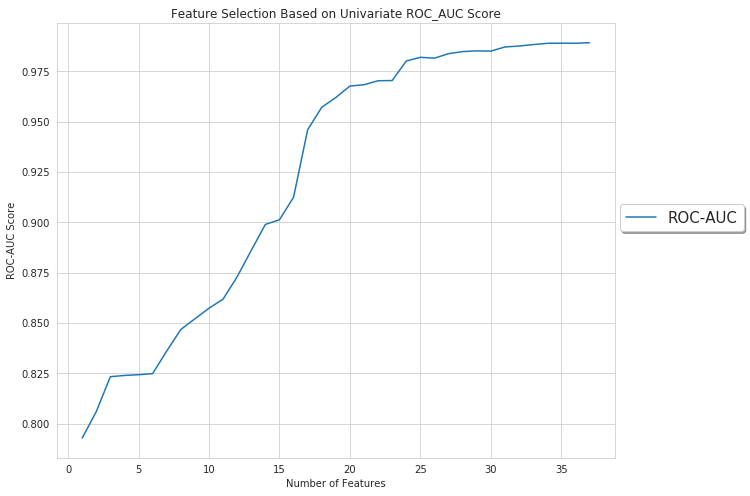

In [91]:
incremental_plot_auc(1,len(sel), title)

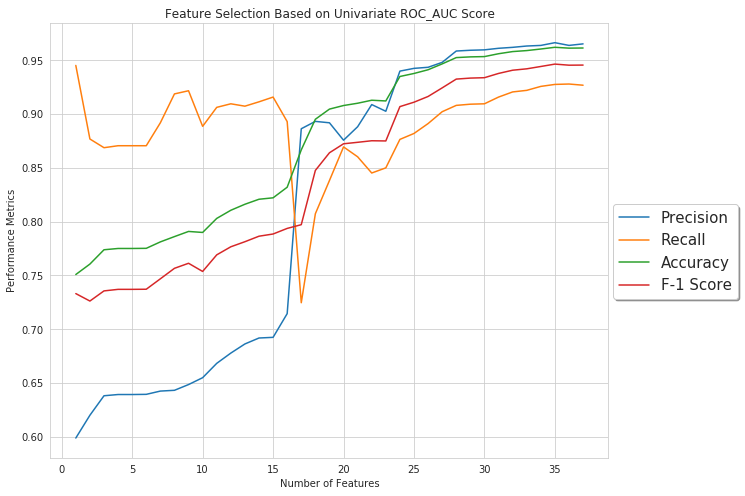

In [92]:
incremental_plot(1,len(sel), title)


## Feature Selection using Principal Component Analysis

In [93]:
clear_metrics()
for component in range(1,74):
    pca = PCA(n_components=component, random_state=0)
    pca.fit(X_train)
    X_pca_optimal = pca.transform(X_validate)
    print('Selected Components: ', component)
    run_randomForest(X_pca_optimal,y_validate,component)
    print()

Selected Components:  1
Classification Report for Random Forest:    1
Accuracy: 0.9016   (+/- 0.0217)
Precision: 0.8569   (+/- 0.0217)
Recall: 0.8746   (+/- 0.0217)
F-1 Score: 0.8655   (+/- 0.0217)
ROC-AUC: 0.9402   (+/- 0.0217)

Selected Components:  2
Classification Report for Random Forest:    2
Accuracy: 0.9437   (+/- 0.0068)
Precision: 0.9323   (+/- 0.0068)
Recall: 0.9110   (+/- 0.0068)
F-1 Score: 0.9214   (+/- 0.0068)
ROC-AUC: 0.9823   (+/- 0.0068)

Selected Components:  3
Classification Report for Random Forest:    3
Accuracy: 0.9471   (+/- 0.0089)
Precision: 0.9400   (+/- 0.0089)
Recall: 0.9121   (+/- 0.0089)
F-1 Score: 0.9257   (+/- 0.0089)
ROC-AUC: 0.9857   (+/- 0.0089)

Selected Components:  4
Classification Report for Random Forest:    4
Accuracy: 0.9554   (+/- 0.0149)
Precision: 0.9507   (+/- 0.0149)
Recall: 0.9250   (+/- 0.0149)
F-1 Score: 0.9376   (+/- 0.0149)
ROC-AUC: 0.9877   (+/- 0.0149)

Selected Components:  5
Classification Report for Random Forest:    5
Accuracy: 

Classification Report for Random Forest:    37
Accuracy: 0.9671   (+/- 0.0070)
Precision: 0.9796   (+/- 0.0070)
Recall: 0.9287   (+/- 0.0070)
F-1 Score: 0.9534   (+/- 0.0070)
ROC-AUC: 0.9914   (+/- 0.0070)

Selected Components:  38
Classification Report for Random Forest:    38
Accuracy: 0.9665   (+/- 0.0069)
Precision: 0.9800   (+/- 0.0069)
Recall: 0.9265   (+/- 0.0069)
F-1 Score: 0.9523   (+/- 0.0069)
ROC-AUC: 0.9911   (+/- 0.0069)

Selected Components:  39
Classification Report for Random Forest:    39
Accuracy: 0.9675   (+/- 0.0067)
Precision: 0.9822   (+/- 0.0067)
Recall: 0.9272   (+/- 0.0067)
F-1 Score: 0.9538   (+/- 0.0067)
ROC-AUC: 0.9913   (+/- 0.0067)

Selected Components:  40
Classification Report for Random Forest:    40
Accuracy: 0.9666   (+/- 0.0058)
Precision: 0.9814   (+/- 0.0058)
Recall: 0.9254   (+/- 0.0058)
F-1 Score: 0.9525   (+/- 0.0058)
ROC-AUC: 0.9913   (+/- 0.0058)

Selected Components:  41
Classification Report for Random Forest:    41
Accuracy: 0.9681   (+/- 0

Classification Report for Random Forest:    73
Accuracy: 0.9674   (+/- 0.0078)
Precision: 0.9863   (+/- 0.0078)
Recall: 0.9228   (+/- 0.0078)
F-1 Score: 0.9534   (+/- 0.0078)
ROC-AUC: 0.9919   (+/- 0.0078)



In [94]:
title = "Feature Selection using Principal Component Analysis"
results_to_csv(title)

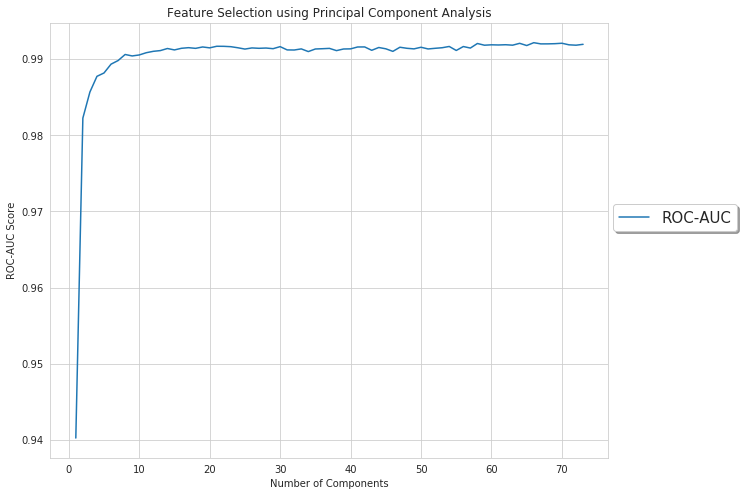

In [95]:
incremental_plot_auc(1,74, title, "Number of Components")

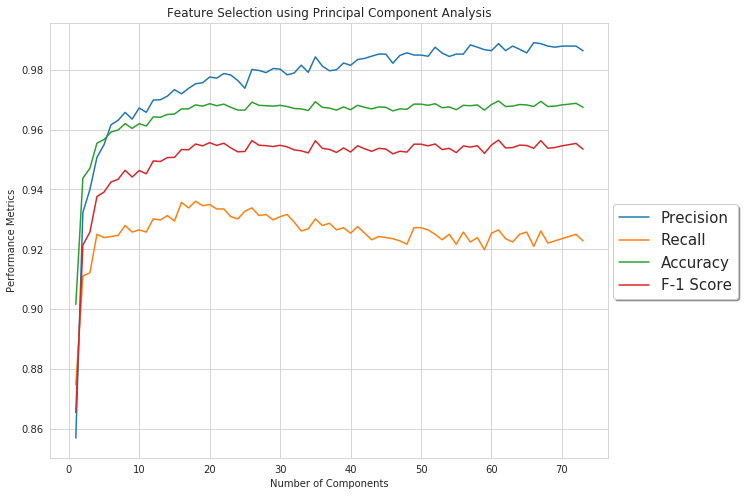

In [96]:
incremental_plot(1,74, title, "Number of Components")


## Feature Selection using RFE (RandomForestClassifier)

In [97]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(1, 74):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
    print(X_transform.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_transform, y_validate, index)

(7518, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.7479   (+/- 0.0282)
Precision: 0.5997   (+/- 0.0282)
Recall: 0.9140   (+/- 0.0282)
F-1 Score: 0.7241   (+/- 0.0282)
ROC-AUC: 0.7839   (+/- 0.0282)
(7518, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.7682   (+/- 0.0349)
Precision: 0.6265   (+/- 0.0349)
Recall: 0.8915   (+/- 0.0349)
F-1 Score: 0.7357   (+/- 0.0349)
ROC-AUC: 0.8164   (+/- 0.0349)
(7518, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.7805   (+/- 0.0204)
Precision: 0.9648   (+/- 0.0204)
Recall: 0.4085   (+/- 0.0204)
F-1 Score: 0.5732   (+/- 0.0204)
ROC-AUC: 0.8795   (+/- 0.0204)
(7518, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.8844   (+/- 0.0320)
Precision: 0.8485   (+/- 0.0320)
Recall: 0.8290   (+/- 0.0320)
F-1 Score: 0.8384   (+/- 0.0320)
ROC-AUC: 0.9325   (+/- 0.0320)
(7518, 5)
Selected Feature:  5
Classification Report for

(7518, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9715   (+/- 0.0077)
Precision: 0.9760   (+/- 0.0077)
Recall: 0.9449   (+/- 0.0077)
F-1 Score: 0.9600   (+/- 0.0077)
ROC-AUC: 0.9925   (+/- 0.0077)
(7518, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9710   (+/- 0.0069)
Precision: 0.9731   (+/- 0.0069)
Recall: 0.9463   (+/- 0.0069)
F-1 Score: 0.9594   (+/- 0.0069)
ROC-AUC: 0.9924   (+/- 0.0069)
(7518, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9715   (+/- 0.0081)
Precision: 0.9753   (+/- 0.0081)
Recall: 0.9456   (+/- 0.0081)
F-1 Score: 0.9601   (+/- 0.0081)
ROC-AUC: 0.9922   (+/- 0.0081)
(7518, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9709   (+/- 0.0087)
Precision: 0.9724   (+/- 0.0087)
Recall: 0.9467   (+/- 0.0087)
F-1 Score: 0.9592   (+/- 0.0087)
ROC-AUC: 0.9926   (+/- 0.0087)
(7518, 40)
Selected Feature:  40
Classificat

(7518, 71)
Selected Feature:  71
Classification Report for Random Forest:    71
Accuracy: 0.9721   (+/- 0.0101)
Precision: 0.9786   (+/- 0.0101)
Recall: 0.9437   (+/- 0.0101)
F-1 Score: 0.9607   (+/- 0.0101)
ROC-AUC: 0.9942   (+/- 0.0101)
(7518, 72)
Selected Feature:  72
Classification Report for Random Forest:    72
Accuracy: 0.9731   (+/- 0.0083)
Precision: 0.9771   (+/- 0.0083)
Recall: 0.9482   (+/- 0.0083)
F-1 Score: 0.9623   (+/- 0.0083)
ROC-AUC: 0.9940   (+/- 0.0083)
(7518, 73)
Selected Feature:  73
Classification Report for Random Forest:    73
Accuracy: 0.9738   (+/- 0.0088)
Precision: 0.9807   (+/- 0.0088)
Recall: 0.9463   (+/- 0.0088)
F-1 Score: 0.9631   (+/- 0.0088)
ROC-AUC: 0.9941   (+/- 0.0088)


In [98]:
title = "Recursive Feature Elimination (RFE) using Random Forest Classifier"
results_to_csv(title)

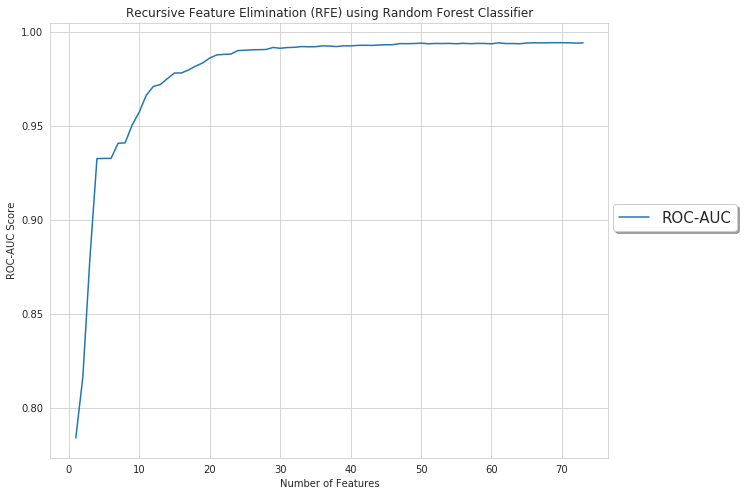

In [99]:
incremental_plot_auc(1,74, title)

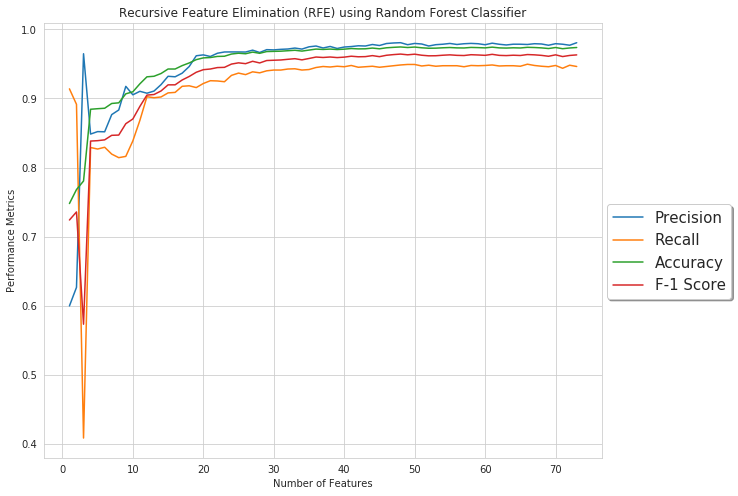

In [100]:
incremental_plot(1,74, title)


In [101]:
#best RFE(Gradient BoostingClassifier) features
clear_metrics()
for index in range(1, 74):
    sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select = index)
    sel.fit(X_train,y_train)
    X_optimal_gradient = sel.transform(X_validate)
    print(X_optimal_gradient.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_optimal_gradient,y_validate, index)

(7518, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.7479   (+/- 0.0282)
Precision: 0.5997   (+/- 0.0282)
Recall: 0.9140   (+/- 0.0282)
F-1 Score: 0.7241   (+/- 0.0282)
ROC-AUC: 0.7839   (+/- 0.0282)
(7518, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.8003   (+/- 0.0297)
Precision: 0.8209   (+/- 0.0297)
Recall: 0.5743   (+/- 0.0297)
F-1 Score: 0.6749   (+/- 0.0297)
ROC-AUC: 0.8593   (+/- 0.0297)
(7518, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8063   (+/- 0.0368)
Precision: 0.8117   (+/- 0.0368)
Recall: 0.6055   (+/- 0.0368)
F-1 Score: 0.6930   (+/- 0.0368)
ROC-AUC: 0.8843   (+/- 0.0368)
(7518, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.8844   (+/- 0.0320)
Precision: 0.8485   (+/- 0.0320)
Recall: 0.8290   (+/- 0.0320)
F-1 Score: 0.8384   (+/- 0.0320)
ROC-AUC: 0.9325   (+/- 0.0320)
(7518, 5)
Selected Feature:  5
Classification Report for

(7518, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9701   (+/- 0.0104)
Precision: 0.9733   (+/- 0.0104)
Recall: 0.9434   (+/- 0.0104)
F-1 Score: 0.9580   (+/- 0.0104)
ROC-AUC: 0.9926   (+/- 0.0104)
(7518, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9705   (+/- 0.0095)
Precision: 0.9732   (+/- 0.0095)
Recall: 0.9445   (+/- 0.0095)
F-1 Score: 0.9585   (+/- 0.0095)
ROC-AUC: 0.9929   (+/- 0.0095)
(7518, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9697   (+/- 0.0104)
Precision: 0.9729   (+/- 0.0104)
Recall: 0.9426   (+/- 0.0104)
F-1 Score: 0.9574   (+/- 0.0104)
ROC-AUC: 0.9929   (+/- 0.0104)
(7518, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9705   (+/- 0.0091)
Precision: 0.9744   (+/- 0.0091)
Recall: 0.9434   (+/- 0.0091)
F-1 Score: 0.9585   (+/- 0.0091)
ROC-AUC: 0.9930   (+/- 0.0091)
(7518, 40)
Selected Feature:  40
Classificat

(7518, 71)
Selected Feature:  71
Classification Report for Random Forest:    71
Accuracy: 0.9733   (+/- 0.0069)
Precision: 0.9790   (+/- 0.0069)
Recall: 0.9467   (+/- 0.0069)
F-1 Score: 0.9624   (+/- 0.0069)
ROC-AUC: 0.9941   (+/- 0.0069)
(7518, 72)
Selected Feature:  72
Classification Report for Random Forest:    72
Accuracy: 0.9735   (+/- 0.0101)
Precision: 0.9782   (+/- 0.0101)
Recall: 0.9482   (+/- 0.0101)
F-1 Score: 0.9628   (+/- 0.0101)
ROC-AUC: 0.9941   (+/- 0.0101)
(7518, 73)
Selected Feature:  73
Classification Report for Random Forest:    73
Accuracy: 0.9738   (+/- 0.0088)
Precision: 0.9807   (+/- 0.0088)
Recall: 0.9463   (+/- 0.0088)
F-1 Score: 0.9631   (+/- 0.0088)
ROC-AUC: 0.9941   (+/- 0.0088)


In [102]:
title = "Recursive Feature Elimination (RFE) using Gradient Boosting Classifier"
results_to_csv(title)

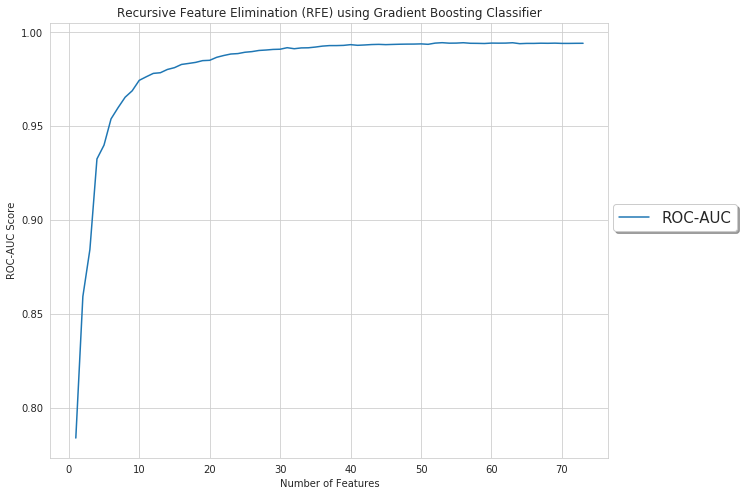

In [103]:
incremental_plot_auc(1,74, title)

ValueError: x and y must have same first dimension, but have shapes (73,) and (35,)

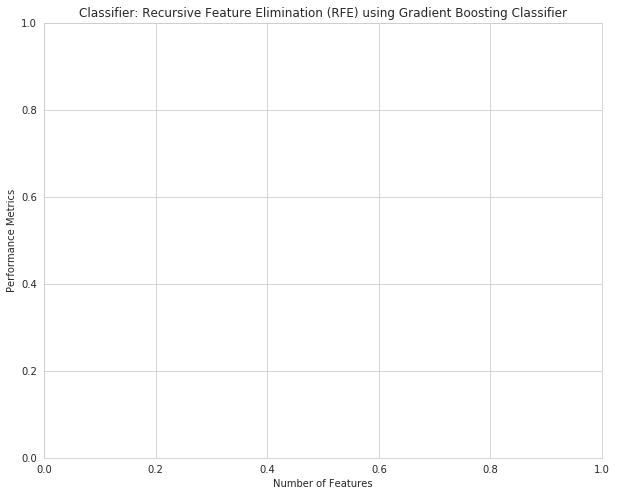

In [188]:
incremental_plot(1,74, title)


## Correlation 

In [141]:
grouped_correlated(to_dataframe(X_train_mutual_info)).shape

# Classifiers Evaluation

## For All Features

In [12]:
%%time
run_randomForest(X, y)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
CPU times: user 54.3 ms, sys: 44.8 ms, total: 99.2 ms
Wall time: 6.65 s


## Recursive Feature Elimination (RFE) using Gradient Boosting Classifier and Random Forest Classifier

In [11]:
clear_metrics()

In [54]:
index =20

In [55]:
%%time
sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, 
                    n_jobs=-1), n_features_to_select=index)
    
sel.fit(X_train,y_train)
X_optimal_gradient = sel.transform(X)
print(X_optimal_gradient.shape)

(15036, 20)
CPU times: user 34.4 s, sys: 1.21 s, total: 35.6 s
Wall time: 23.4 s


In [56]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_optimal_gradient,y, index)

Classification Report for Random Forest:    20
Accuracy: 0.9605   (+/- 0.0062)
Precision: 0.9649   (+/- 0.0062)
Recall: 0.9270   (+/- 0.0062)
F-1 Score: 0.9455   (+/- 0.0062)
ROC-AUC: 0.9894   (+/- 0.0062)
CPU times: user 78 ms, sys: 69.4 ms, total: 147 ms
Wall time: 5.3 s


In [15]:
selected_rfe_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':sel.ranking_})
selected_rfe_features.sort_values(by='Ranking')


,Feature,Ranking
0,transact,1
58,Runtime.exec,1
56,HttpUriRequest,1
22,TelephonyManager.getLine1Number,1
30,android.telephony.gsm.SmsManager,1
...,...,...
63,ACCOUNT_MANAGER,43
72,Runtime.loadLibrary,44
60,MessengerService,45
67,Context.bindService,46


In [16]:
with open('top_drebin.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Feature','Ranking'])
        writer.writerows(zip(selected_rfe_features.Feature, selected_rfe_features.Ranking))

In [17]:
X.columns[sel.support_]

Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast', 'Ljava.net.URLDecoder',
       'android.content.pm.Signature', 'android.telephony.SmsManager',
       'ClassLoader', 'Landroid.content.Context.registerReceiver',
       'Ljava.lang.Class.getField', 'android.content.pm.PackageInfo',
       'TelephonyManager.getLine1Number', 'Ljava.lang.Class.getMethod',
       'android.telephony.gsm.SmsManager', 'TelephonyManager.getSubscriberId',
       'Ljava.lang.Object.getClass', 'TelephonyManager.getDeviceId',
       'HttpUriRequest', 'Runtime.exec', 'TelephonyManager.getNetworkOperator',
       'onBind', 'Ljava.lang.Class.getResource'],
      dtype='object')

In [68]:
X_optimal_gradient

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1]])

In [67]:
X_top = to_dataframe(X_optimal_gradient)
X_top

(15036, 20)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,1,1
5,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15032,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1
15033,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,1
15034,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
15035,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,1,1,1


In [27]:
X_grouped = grouped_correlated(to_dataframe(X_optimal_gradient))

(15036, 25)
    features1  features2  corr_value
0           5          3    0.994622
1           3          5    0.994622
2           2          5    0.984796
3           5          2    0.984796
4           3          2    0.983198
5           2          3    0.983198
6           4          1    0.963364
7           1          4    0.963364
8           1          6    0.881938
9           6          1    0.881938
10          6          4    0.861441
11          4          6    0.861441


NameError: name 'corrdatar' is not defined

<Figure size 1440x1440 with 0 Axes>

In [40]:
%%time
#print('Selected Feature: ', X_grouped.shape[1])
run_randomForest(X_grouped,y, index)

Classification Report for Random Forest:    19
Accuracy: 0.9538   (+/- 0.0086)
Precision: 0.9603   (+/- 0.0086)
Recall: 0.9129   (+/- 0.0086)
F-1 Score: 0.9360   (+/- 0.0086)
ROC-AUC: 0.9855   (+/- 0.0086)
CPU times: user 69.1 ms, sys: 616 µs, total: 69.7 ms
Wall time: 3.75 s


In [249]:
title = "Classifier: Recursive Feature Elimination (RFE) using Random Forest Classifier"
results_to_csv(title)

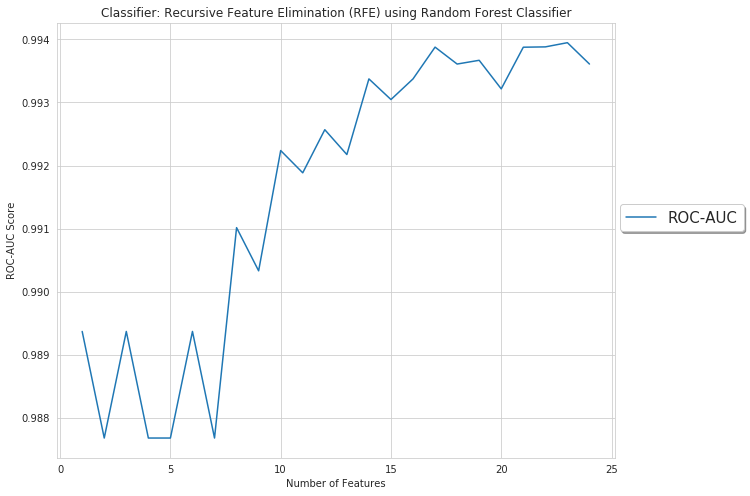

In [253]:
incremental_plot_auc(1,25, title)

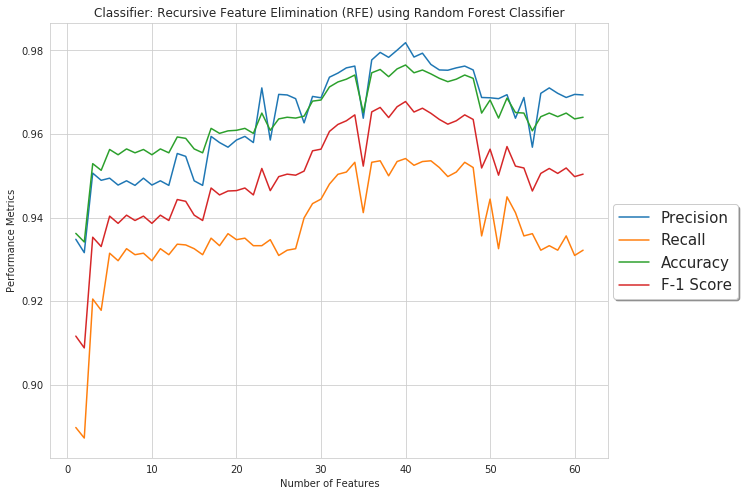

In [550]:
incremental_plot(1,62, title)


## Feature Importance (Extra Trees and Random Forest Classifier

In [12]:
clear_metrics()

In [26]:
index = 24

In [27]:
top_api_indexes = feat_importances.nlargest(index).index
X_top_feat_imps = X.loc[:,top_api_indexes ]
print(X_top_feat_imps.shape)

(15036, 24)


In [28]:
%%time
run_randomForest(X_top_feat_imps,y, index)

Classification Report for Random Forest:    24
Accuracy: 0.9640   (+/- 0.0084)
Precision: 0.9694   (+/- 0.0084)
Recall: 0.9322   (+/- 0.0084)
F-1 Score: 0.9504   (+/- 0.0084)
ROC-AUC: 0.9917   (+/- 0.0084)
CPU times: user 65.7 ms, sys: 1.01 ms, total: 66.7 ms
Wall time: 4.13 s


In [29]:
X_grouped = grouped_correlated(X_top_feat_imps)

(15036, 20)


In [30]:
%%time
run_randomForest(X_grouped,y, index)

Classification Report for Random Forest:    24
Accuracy: 0.9614   (+/- 0.0093)
Precision: 0.9662   (+/- 0.0093)
Recall: 0.9282   (+/- 0.0093)
F-1 Score: 0.9468   (+/- 0.0093)
ROC-AUC: 0.9910   (+/- 0.0093)
CPU times: user 43.4 ms, sys: 3.34 ms, total: 46.7 ms
Wall time: 3.83 s


In [569]:
clear_metrics()

In [616]:
index = 14

In [617]:
pca = PCA(n_components=index, random_state=0)
pca.fit(X_train)
X_pca_optimal = pca.transform(X)

In [618]:
%%time
run_randomForest(X_pca_optimal,y, index)

Classification Report for Random Forest:    14
Accuracy: 0.9745   (+/- 0.0100)
Precision: 0.9795   (+/- 0.0100)
Recall: 0.9509   (+/- 0.0100)
F-1 Score: 0.9650   (+/- 0.0100)
ROC-AUC: 0.9948   (+/- 0.0100)
CPU times: user 63.3 ms, sys: 4.01 ms, total: 67.3 ms
Wall time: 9.4 s


## Random Forest Classifiers for all APIs

In [130]:
%%time
run_randomForest(X, y)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
CPU times: user 30.6 ms, sys: 8 ms, total: 38.6 ms
Wall time: 2.88 s


In [105]:
top_api_indexes = []
top_api_indexes = featureScores.Score.nlargest(40).index
X_top_feat_imps = X_grouped_correlated.iloc[0:,top_api_indexes]

In [106]:
%%time
run_randomForest(X_top_feat_imps, y)

Classification Report for Random Forest:    0
Accuracy: 0.9734   (+/- 0.0072)
Precision: 0.9785   (+/- 0.0072)
Recall: 0.9489   (+/- 0.0072)
F-1 Score: 0.9635   (+/- 0.0072)
ROC-AUC: 0.9946   (+/- 0.0072)
CPU times: user 42.6 ms, sys: 3.81 ms, total: 46.4 ms
Wall time: 2.42 s
